In [1]:
import gibbs_mcmc_nn as mc #imports the file with all the functions of the Gibbs sampler
import torch
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Introduction
In this notebook we will have multiple tests for the Gibbs sampler. Being this a probabilistic algorithm, we cannot check that the output is equal to a known value. Instead our tests will rely on two methods:
1. In the setting of synthetic data, generated with the teacher-student model, we initialize the student on the teacher's weights. Probability tells us that this initialization is already thermalized at $t=0$, hance most observables, such as the norm of the weights must be stationary throughout the simulation. Any sign of non stationarity means that the MCMC is not sampling from the correct posterior.
2. We track the score (i.e. $\partial_W\log P$, with $P$ the intermediate noise posterior distribution) as a function of time. The score has mean zero under the correct posterior: if the score does not oscillate around zero in the Gibbs sampler ti means there's a bug.


The structure of the tests is not standard, as multiple functions are tested together. Usually we look at a certain network architecture and see if all functions involved in sampling form its posterior are doing their job.

For this reason, if one is interested in tests involving a particular function, it is recommended to do `Ctrl+F` to look for the name of the function and subsequently run the corresponding tests. The notebook is thought to be run sequentially, as different sections might be interdependent.

# Test fully connected network

Let's start by defining the neural network's architecture and the posterior that we wish to sample. We will focus on a neural net with input dimension $d^{(1)}=50$, $d^{(2)}=10$ hidden units and a scalar output. We use ReLU activations. The neural network function is $f(\cdot,W):\mathbb R^d\mapsto \mathbb R$,
\begin{equation}
f(x,W)=b^{(2)}+\sum_{\alpha=1}^{d_2}W^{(2)}_\alpha \sigma\left(W^{(1)T}_\alpha x+b^{(1)}_\alpha\right)
\end{equation}
with the weight matrices $W^{(1)}\in\mathbb R^{d_2 \times d_1}$, $W^{(2)}\in\mathbb R^{1 \times d_2}$, $b^{(1)}\in\mathbb R^{d_2}$, $b^{(2)}\in\mathbb R$. The input vector $x$ lives in $\mathbb R^{d_1}$ and $\sigma(x)=\max(0,x)$.


By sampling the resulting intermediate noise posterior we will test the functions  `sample_W_l_fcl`, `sample_b_l_fcl`, `sample_X_l_fcl`, `sample_Z_lp1_relu`.


In [3]:
def MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X):
    return (sigma(X@W_1.T+b_1))@(W_2.T)+b_2[None,:]

#used to compute the score function (multiplied by Delta). Each component of the score should have mean zero under the posterior.
def score_W_l_resc(W_l,X_l,Z_lp1,b_l,lambda_W_l,Delta_Z_lp1): 
    """
    computes the gradient (w.r.t. W) of the log posterior multiplied by Delta_Z.
    This is the score multiplied by Delta_Z
    Returns a matrix with the same shape as the weights W_l
    """
    return torch.tensordot(Z_lp1-X_l@(W_l.T)-b_l[None,:], X_l,[[0],[0]])-Delta_Z_lp1*lambda_W_l*W_l

In [4]:
n=2084
d_1=torch.tensor(50)
d_2=torch.tensor(10)
sigma=torch.nn.ReLU()
lambda_W_1_teach=d_1
lambda_b_1_teach=d_1
lambda_W_2_teach=d_2
lambda_b_2_teach=d_2
Delta_teach=torch.tensor(1e-3)
n_test=2000

X_train=torch.randn(size=[n,d_1])
W_1_teach=torch.randn(size=[d_2,d_1])/torch.sqrt(lambda_W_1_teach)
b_1_teach=torch.randn(size=[d_2])/torch.sqrt(lambda_b_1_teach)
W_2_teach=torch.randn(size=[1,d_2])/torch.sqrt(lambda_W_2_teach)
b_2_teach=torch.randn(size=[1])/torch.sqrt(lambda_b_2_teach)

Z_2_teach=X_train@(W_1_teach.T)+b_1_teach[None,:]+torch.sqrt(Delta_teach)*torch.randn(size=[n,d_2])
X_2_teach=sigma(Z_2_teach)+torch.sqrt(Delta_teach)*torch.randn(size=[n,d_2])
y_train=b_2_teach[None,:]+X_2_teach@(W_2_teach.T)+torch.sqrt(Delta_teach)*torch.randn(size=[n,1])
y_train_noiseless=MLP_1_hidden_layer(sigma,W_1_teach,b_1_teach,W_2_teach,b_2_teach,X_train)

#generate test set
X_test=torch.randn(size=[n_test,d_1])
y_test=MLP_1_hidden_layer(sigma,W_1_teach,b_1_teach,W_2_teach,b_2_teach,X_test)

In [5]:
Delta=Delta_teach.clone()
lambda_W_1=lambda_W_1_teach.clone()
lambda_W_2=lambda_W_2_teach.clone()
lambda_b_1=lambda_b_1_teach.clone()
lambda_b_2=lambda_b_2_teach.clone()


## Initialization
We set all variables initially to zero or to the value of the teacher's counterparts.


In [6]:
"""
#zero initialization
W_1=torch.zeros(size=[d_2,d_1])
b_1=torch.zeros(size=[d_2])
Z_2=torch.zeros(size=[n,d_2])
X_2=torch.zeros(size=[n,d_2])
W_2=torch.zeros(size=[1,d_2])
b_2=torch.zeros(size=[1])
"""


#informed initialization
W_1=W_1_teach.clone()
b_1=b_1_teach.clone()
Z_2=Z_2_teach.clone()
X_2=X_2_teach.clone()
W_2=W_2_teach.clone()
b_2=b_2_teach.clone()


In [7]:
#moving the variables to the GPU (if needed)
Delta=Delta.to(device)
lambda_W_1=lambda_W_1.to(device)
lambda_b_1=lambda_b_1.to(device)
lambda_W_2=lambda_W_2.to(device)
lambda_b_2=lambda_b_2.to(device)
W_1=W_1.to(device)
b_1=b_1.to(device)
Z_2=Z_2.to(device)
X_2=X_2.to(device)
W_2=W_2.to(device)
b_2=b_2.to(device)
X_train=X_train.to(device)
y_train=y_train.to(device)
y_train_noiseless=y_train_noiseless.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)
if(str(device)=='cuda'): 
    torch.set_default_tensor_type(torch.cuda.FloatTensor) #this is necessary so that tensors generated during the algorithm are allocated on the GPU

In [8]:
#stuff to track during the dynamics
test_loss=[]
train_loss_noiseless=[]
train_loss=[]
b_1_norm=[]
b_2_norm=[]
W_1_norm=[]
W_2_norm=[]
y_pred_train_norm=[] #squared norm of the predictions on the training set
score_resc_W_1=[]
score_resc_W_2=[]
tmax=5000

This tests the functions  `sample_W_l_fcl`, `sample_b_l_fcl`, `sample_X_l_fcl`, `sample_Z_lp1_relu`.

In [9]:
#should take about 1 minute to run
for t in range(tmax):
    y_pred_test=MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_test)
    y_pred_train=MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_train)
    test_loss.append(torch.mean((y_pred_test-y_test)**2).item())
    train_loss_noiseless.append(torch.mean((y_pred_train-y_train_noiseless)**2).item())
    train_loss.append(torch.mean((y_pred_train-y_train)**2).item())
    y_pred_train_norm.append(torch.linalg.norm(y_pred_train).item()) #mean square of the components of y
    W_1_norm.append(torch.linalg.norm(W_1).item())
    W_2_norm.append(torch.linalg.norm(W_2).item())
    b_1_norm.append(torch.linalg.norm(b_1).item())
    b_2_norm.append(torch.linalg.norm(b_2).item())
    score_resc_W_1.append(torch.mean(score_W_l_resc(W_1,X_train,Z_2,b_1,lambda_W_1,Delta)).item())
    score_resc_W_2.append(torch.mean(score_W_l_resc(W_2,X_2,y_train,b_2,lambda_W_2,Delta)).item())




    #updating the variables (in this case in reverse order)
    W_2=mc.sample_W_l_fcl(X_2,b_2,y_train,lambda_W_2,Delta)
    b_2=mc.sample_b_l_fcl(W_2,y_train,X_2,Delta,lambda_b_2)
    X_2=mc.sample_X_l_fcl(sigma(Z_2),W_2,b_2,y_train,Delta,Delta) 
    Z_2=mc.sample_Z_lp1_relu(X_train@(W_1.T)+b_1[None,:],X_2,Delta,Delta)
    W_1=mc.sample_W_l_fcl(X_train,b_1,Z_2,lambda_W_1,Delta)
    b_1=mc.sample_b_l_fcl(W_1,Z_2,X_train,Delta,lambda_b_1)

In the following plot, with informed initialization the train noiseless MSE and test MSE should increase until a plateau is reached. Instead the train MSE should be stationary. When initializing to zero all three observables should decrease until they ancounter a plateau.

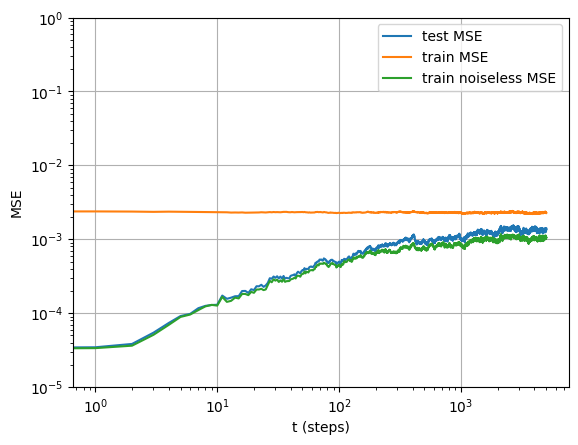

In [10]:
plt.plot(test_loss,label="test MSE")
plt.plot(train_loss,label="train MSE")
plt.plot(train_loss_noiseless,label="train noiseless MSE")

plt.xlabel("t (steps)")
plt.ylabel("MSE")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.ylim([1e-5,1])
plt.legend()

All quantities in the following plot should be stationary. Moreover the scores (i.e. $\Delta\partial_W\log P$ with $P$ the posterior) should have mean zero.

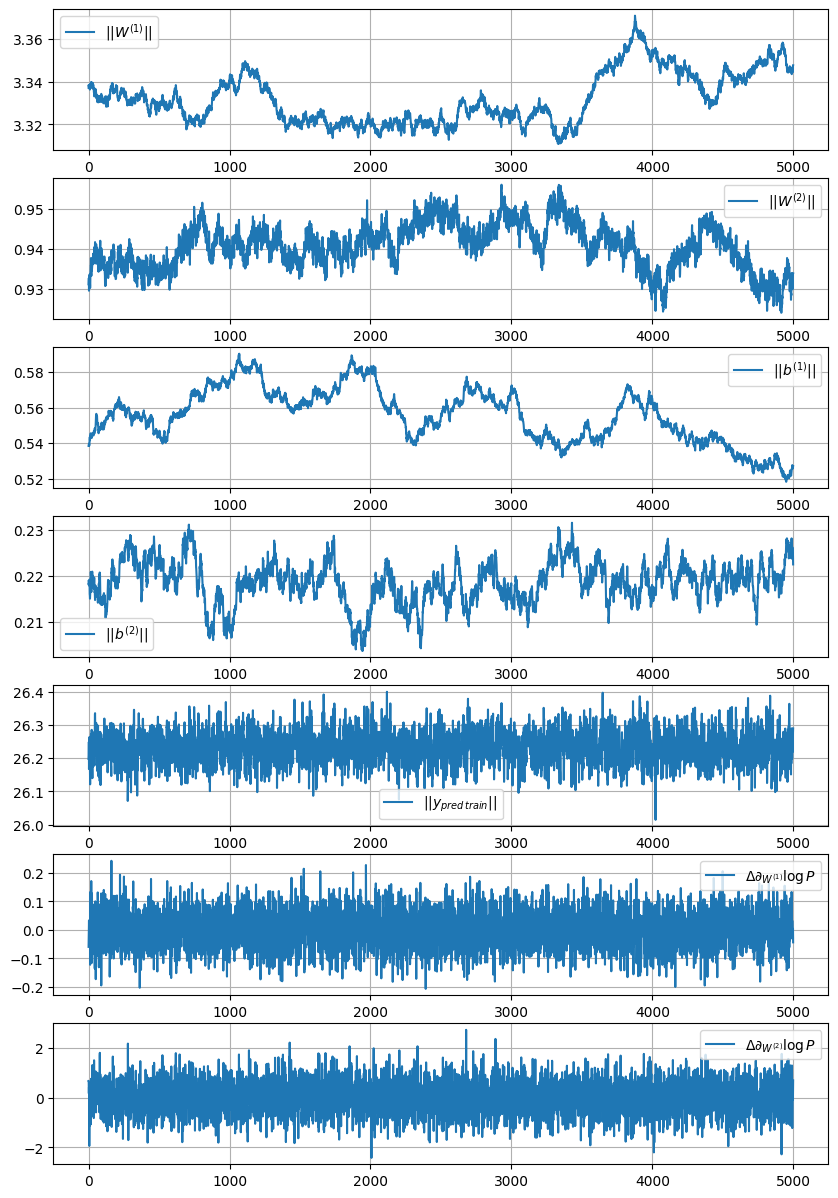

In [11]:
fig,axes=plt.subplots(7,1,figsize=[10,15])
axes[0].plot(W_1_norm[:],label=r"$||W^{(1)}||$")
axes[0].legend()
axes[0].grid()
axes[1].plot(W_2_norm[:],label=r"$||W^{(2)}||$")
axes[1].legend()
axes[1].grid()
axes[2].plot(b_1_norm[:],label=r"$||b^{(1)}||$")
axes[2].legend()
axes[2].grid()
axes[3].plot(b_2_norm[:],label=r"$||b^{(2)}||$")
axes[3].legend()
axes[3].grid()
axes[4].plot(y_pred_train_norm[:],label=r"$||y_{pred \,train}||$")
axes[4].legend()
axes[4].grid()
axes[5].plot(score_resc_W_1[:],label=r"$\Delta\partial_{W^{(1)}}\log P$")
axes[5].legend()
axes[5].grid()
axes[6].plot(score_resc_W_2[:],label=r"$\Delta\partial_{W^{(2)}}\log P$")
axes[6].legend()
axes[6].grid()

## Testing the faster implementation

The sampling of the first layer's weights can be sped up by precomputing the covarinace (and its cholesky decomposition) of the first layer's weights and biases. Also exploiting a simplification when sampling $X^{(2)}$ for the case when the output has only one neuron.
The larger the input dimension $d_1$ the more significant the speedup.

This tests the functions `sample_W_b_1_fcl`, `mc.sample_X_L_fcl`.

In [12]:
"""
#initializing all variables to zero
W_1=torch.zeros(size=[d_2,d_1])
b_1=torch.zeros(size=[d_2])
Z_2=torch.zeros(size=[n,d_2])
X_2=torch.zeros(size=[n,d_2])
W_2=torch.zeros(size=[1,d_2])
b_2=torch.zeros(size=[1])
"""
#informed initialization
W_1=W_1_teach.clone()
b_1=b_1_teach.clone()
Z_2=Z_2_teach.clone()
X_2=X_2_teach.clone()
W_2=W_2_teach.clone()
b_2=b_2_teach.clone()

#moving the variables to the GPU (if needed)
Delta=Delta.to(device)
lambda_W_1=lambda_W_1.to(device)
lambda_b_1=lambda_b_1.to(device)
lambda_W_2=lambda_W_2.to(device)
lambda_b_2=lambda_b_2.to(device)
W_1=W_1.to(device)
b_1=b_1.to(device)
Z_2=Z_2.to(device)
X_2=X_2.to(device)
W_2=W_2.to(device)
b_2=b_2.to(device)
X_train=X_train.to(device)
y_train=y_train.to(device)
y_train_noiseless=y_train_noiseless.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)
if(str(device)=='cuda'): 
    torch.set_default_tensor_type(torch.cuda.FloatTensor) #this is necessary so that tensors generated during the algorithm are allocated on the GPU

#precomputing quantities to sample the first layer's weights and biases faster
sum_X=torch.sum(X_train,axis=0)[None,:]
up_block=torch.cat((torch.tensor([[lambda_b_1*Delta+n]]),sum_X),axis=1)
down_block=torch.cat((sum_X.T,(X_train.T)@X_train+Delta*lambda_W_1*torch.eye(d_1)),axis=1)
Cov_W_b_resc=torch.linalg.inv(torch.cat((up_block,down_block),axis=0))
Cholesky_Cov_W_b_resc=torch.linalg.cholesky(Cov_W_b_resc) 
Cov_W_b_resc_XT = Cov_W_b_resc @ torch.cat((torch.ones([n,1]),X_train),axis=1).T 

In [13]:
test_loss=[]
train_loss_noiseless=[]
train_loss=[]
b_1_norm=[]
b_2_norm=[]
W_1_norm=[]
W_2_norm=[]
y_pred_train_norm=[] #squared norm of the predictions on the training set
score_resc_W_1=[]
score_resc_W_2=[]
tmax=5000

In [14]:
#should take about 1 minute to run
for t in range(tmax):
    y_pred_test=MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_test)
    y_pred_train=MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_train)
    test_loss.append(torch.mean((y_pred_test-y_test)**2).item())
    train_loss_noiseless.append(torch.mean((y_pred_train-y_train_noiseless)**2).item())
    train_loss.append(torch.mean((y_pred_train-y_train)**2).item())
    y_pred_train_norm.append(torch.linalg.norm(y_pred_train).item()) #mean square of the components of y
    W_1_norm.append(torch.linalg.norm(W_1).item())
    W_2_norm.append(torch.linalg.norm(W_2).item())
    b_1_norm.append(torch.linalg.norm(b_1).item())
    b_2_norm.append(torch.linalg.norm(b_2).item())
    score_resc_W_1.append(torch.mean(score_W_l_resc(W_1,X_train,Z_2,b_1,lambda_W_1,Delta)).item())
    score_resc_W_2.append(torch.mean(score_W_l_resc(W_2,X_2,y_train,b_2,lambda_W_2,Delta)).item())

    #updating the variables (in this case in reverse order)
    W_2=mc.sample_W_l_fcl(X_2,b_2,y_train,lambda_W_2,Delta)
    b_2=mc.sample_b_l_fcl(W_2,y_train,X_2,Delta,lambda_b_2)
    X_2=mc.sample_X_L_fcl(sigma(Z_2),W_2,b_2,y_train,Delta,Delta)
    Z_2=mc.sample_Z_lp1_relu(X_train@(W_1.T)+b_1[None,:],X_2,Delta,Delta)
    W_1,b_1=mc.sample_W_b_1_fcl(Cholesky_Cov_W_b_resc,Cov_W_b_resc_XT,Z_2,Delta)

In the following plot, with informed initialization the train noiseless MSE and test MSE should increase until a plateau is reached. Instead the train MSE should be stationary. When initializing to zero all three observables should decrease until they ancounter a plateau.

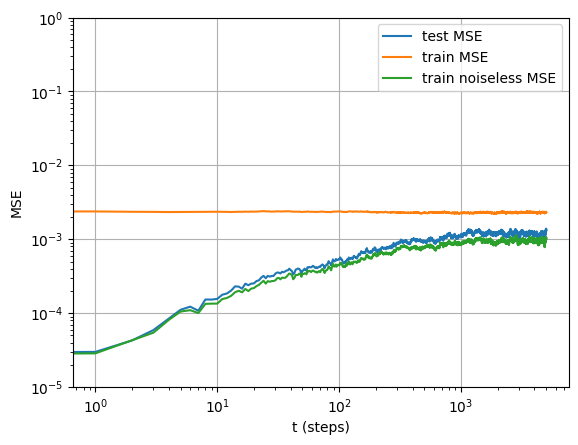

In [15]:
plt.plot(test_loss,label="test MSE")
plt.plot(train_loss,label="train MSE")
plt.plot(train_loss_noiseless,label="train noiseless MSE")
plt.xlabel("t (steps)")
plt.ylabel("MSE")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.ylim([1e-5,1])
plt.legend()

All quantities in the following plot should be stationary. Moreover the scores (i.e. $\Delta\partial_W\log P$ with $P$ the posterior) should have mean zero.

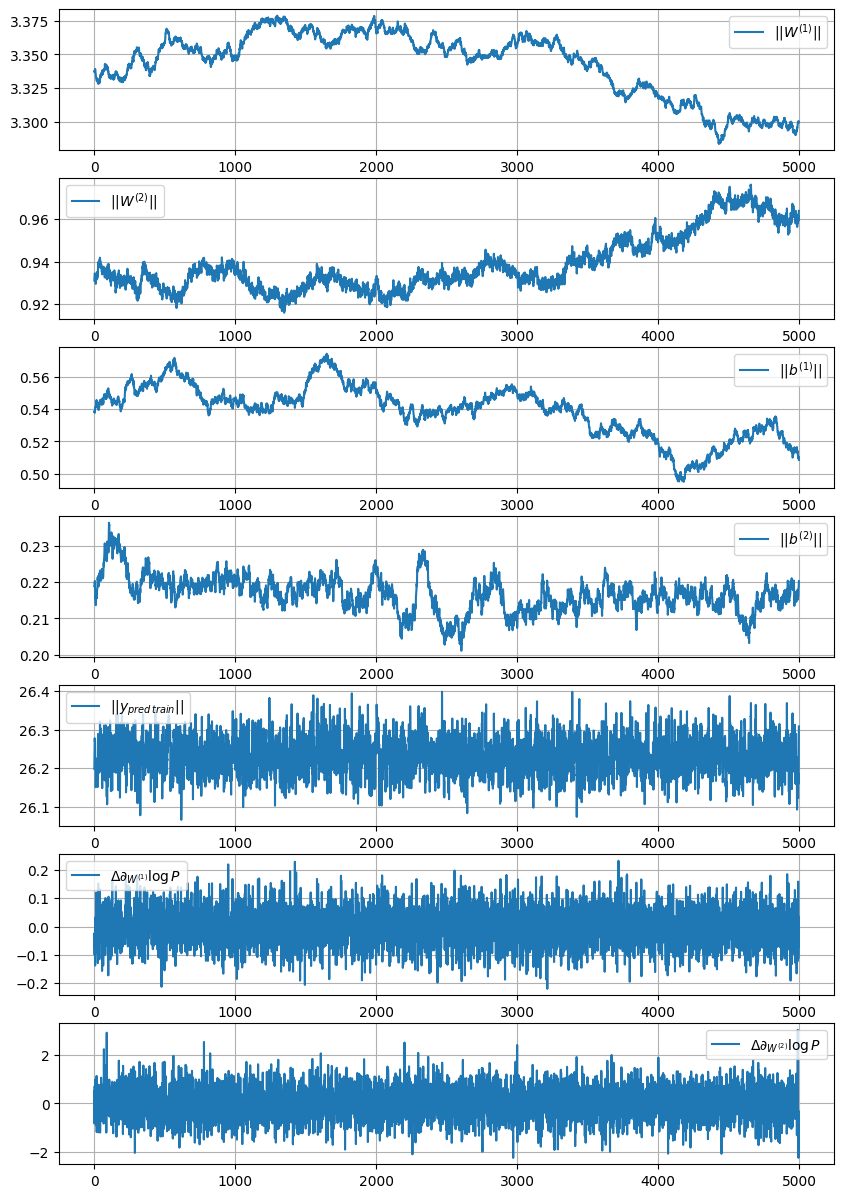

In [16]:
fig,axes=plt.subplots(7,1,figsize=[10,15])
axes[0].plot(W_1_norm[:],label=r"$||W^{(1)}||$")
axes[0].legend()
axes[0].grid()
axes[1].plot(W_2_norm[:],label=r"$||W^{(2)}||$")
axes[1].legend()
axes[1].grid()
axes[2].plot(b_1_norm[:],label=r"$||b^{(1)}||$")
axes[2].legend()
axes[2].grid()
axes[3].plot(b_2_norm[:],label=r"$||b^{(2)}||$")
axes[3].legend()
axes[3].grid()
axes[4].plot(y_pred_train_norm[:],label=r"$||y_{pred \,train}||$")
axes[4].legend()
axes[4].grid()
axes[5].plot(score_resc_W_1[:],label=r"$\Delta\partial_{W^{(1)}}\log P$")
axes[5].legend()
axes[5].grid()
axes[6].plot(score_resc_W_2[:],label=r"$\Delta\partial_{W^{(2)}}\log P$")
axes[6].legend()
axes[6].grid()

# Test `sample_W_1_fcl` , `sample_W_b_l_fcl` 

We make two modifications in order to test these functions
1. We modify the function to sample the first layer weights: we use `sample_W_1_fcl`. In this new setting the first layer's weights and biases are sampled separately. However it still benefits from the precomputed quantities when sampling `W_1`.

2. We modify the function to sample the second layer weights and biases.We use `sample_W_b_l_fcl`. Instead of sampling them separately this function samples them jointly.

 

In [17]:
"""
#initializing all variables to zero
W_1=torch.zeros(size=[d_2,d_1])
b_1=torch.zeros(size=[d_2])
Z_2=torch.zeros(size=[n,d_2])
X_2=torch.zeros(size=[n,d_2])
W_2=torch.zeros(size=[1,d_2])
b_2=torch.zeros(size=[1])
"""
#informed initialization
W_1=W_1_teach.clone()
b_1=b_1_teach.clone()
Z_2=Z_2_teach.clone()
X_2=X_2_teach.clone()
W_2=W_2_teach.clone()
b_2=b_2_teach.clone()

#moving the variables to the GPU (if needed)
Delta=Delta.to(device)
lambda_W_1=lambda_W_1.to(device)
lambda_b_1=lambda_b_1.to(device)
lambda_W_2=lambda_W_2.to(device)
lambda_b_2=lambda_b_2.to(device)
W_1=W_1.to(device)
b_1=b_1.to(device)
Z_2=Z_2.to(device)
X_2=X_2.to(device)
W_2=W_2.to(device)
b_2=b_2.to(device)
X_train=X_train.to(device)
y_train=y_train.to(device)
y_train_noiseless=y_train_noiseless.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)
if(str(device)=='cuda'): 
    torch.set_default_tensor_type(torch.cuda.FloatTensor) #this is necessary so that tensors generated during the algorithm are allocated on the GPU

#precomputing quantities to sample the first layer's weights and biases faster
Cov_W_resc=torch.linalg.inv(X_train.T@X_train+Delta*lambda_W_1*torch.eye(d_1))
Cov_W_resc_XT=Cov_W_resc@(X_train.T)
Cholesky_Cov_W_resc= torch.linalg.cholesky(Cov_W_resc)

Cov_W_resc_XT=Cov_W_resc_XT.to(device)
Cholesky_Cov_W_resc=Cholesky_Cov_W_resc.to(device)

In [18]:
test_loss=[]
train_loss_noiseless=[]
train_loss=[]
b_1_norm=[]
b_2_norm=[]
W_1_norm=[]
W_2_norm=[]
y_pred_train_norm=[] #squared norm of the predictions on the training set
score_resc_W_1=[]
score_resc_W_2=[]
tmax=5000

In [19]:
#should take about 1 minute to run
for t in range(tmax):
    y_pred_test=MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_test)
    y_pred_train=MLP_1_hidden_layer(sigma,W_1,b_1,W_2,b_2,X_train)
    test_loss.append(torch.mean((y_pred_test-y_test)**2).item())
    train_loss_noiseless.append(torch.mean((y_pred_train-y_train_noiseless)**2).item())
    train_loss.append(torch.mean((y_pred_train-y_train)**2).item())
    y_pred_train_norm.append(torch.linalg.norm(y_pred_train).item()) #mean square of the components of y
    W_1_norm.append(torch.linalg.norm(W_1).item())
    W_2_norm.append(torch.linalg.norm(W_2).item())
    b_1_norm.append(torch.linalg.norm(b_1).item())
    b_2_norm.append(torch.linalg.norm(b_2).item())
    score_resc_W_1.append(torch.mean(score_W_l_resc(W_1,X_train,Z_2,b_1,lambda_W_1,Delta)).item())
    score_resc_W_2.append(torch.mean(score_W_l_resc(W_2,X_2,y_train,b_2,lambda_W_2,Delta)).item())

    #updating the variables (in this case in reverse order)
    W_2,b_2=mc.sample_W_b_l_fcl(X_2,y_train,lambda_W_2,lambda_b_2,Delta)
    X_2=mc.sample_X_L_fcl(sigma(Z_2),W_2,b_2,y_train,Delta,Delta)
    Z_2=mc.sample_Z_lp1_relu(X_train@(W_1.T)+b_1[None,:],X_2,Delta,Delta)
    W_1=mc.sample_W_1_fcl(Z_2,b_1,Cholesky_Cov_W_resc,Cov_W_resc_XT,Delta)
    b_1=mc.sample_b_l_fcl(W_1,Z_2,X_train,Delta,lambda_b_1)

In the following plot, with informed initialization the train noiseless MSE and test MSE should increase until a plateau is reached. Instead the train MSE should be stationary. When initializing to zero all three observables should decrease until they ancounter a plateau.

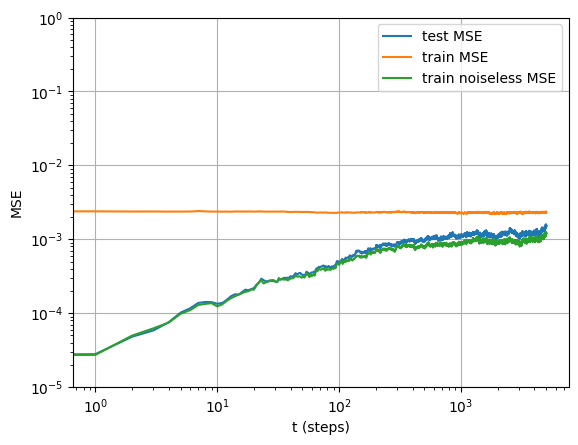

In [20]:
plt.plot(test_loss,label="test MSE")
plt.plot(train_loss,label="train MSE")
plt.plot(train_loss_noiseless,label="train noiseless MSE")
plt.xlabel("t (steps)")
plt.ylabel("MSE")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.ylim([1e-5,1])
plt.legend()

All quantities in the following plot should be stationary. Moreover the scores (i.e. $\Delta\partial_W\log P$ with $P$ the posterior) should have mean zero.

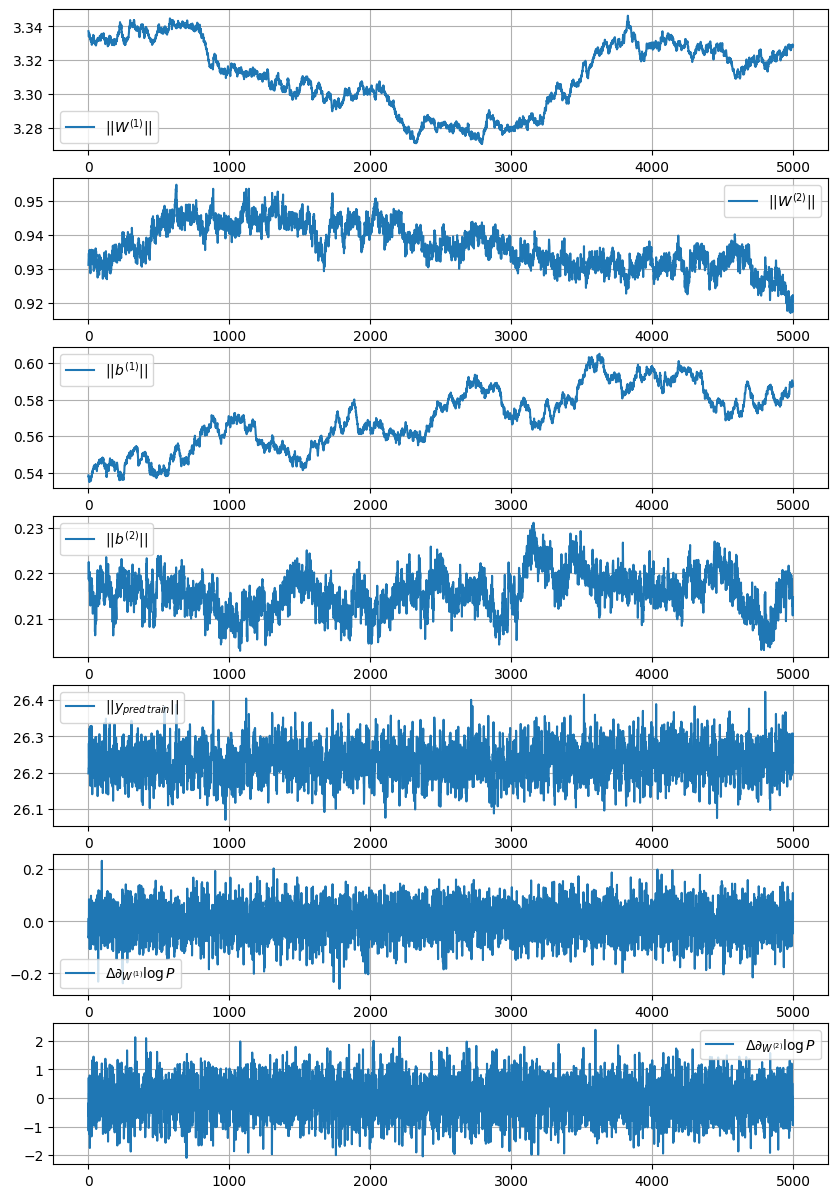

In [21]:
fig,axes=plt.subplots(7,1,figsize=[10,15])
axes[0].plot(W_1_norm[:],label=r"$||W^{(1)}||$")
axes[0].legend()
axes[0].grid()
axes[1].plot(W_2_norm[:],label=r"$||W^{(2)}||$")
axes[1].legend()
axes[1].grid()
axes[2].plot(b_1_norm[:],label=r"$||b^{(1)}||$")
axes[2].legend()
axes[2].grid()
axes[3].plot(b_2_norm[:],label=r"$||b^{(2)}||$")
axes[3].legend()
axes[3].grid()
axes[4].plot(y_pred_train_norm[:],label=r"$||y_{pred \,train}||$")
axes[4].legend()
axes[4].grid()
axes[5].plot(score_resc_W_1[:],label=r"$\Delta\partial_{W^{(1)}}\log P$")
axes[5].legend()
axes[5].grid()
axes[6].plot(score_resc_W_2[:],label=r"$\Delta\partial_{W^{(2)}}\log P$")
axes[6].legend()
axes[6].grid()

# Test multinomial layer.
We now test the function `sample_Z_Lp1_multinomial_probit`. 
We do so in the simple case of a one layer network, with $C=4$ output classes.
This is basically equivalent to doing Bayes optimal regression in the multinomial probit model, with biases and gaussian prior on weights.


In [22]:
d=torch.tensor(10)#input dimension
C=torch.tensor(4)# number of classes (i.e. width of the output layer)
n=torch.tensor(500) #number of training samples #2000
n_test=2000
Delta=torch.tensor(1)

lambda_W=d
lambda_b=d


In [23]:
def score_Z_resc(X,W,b,Z,Delta_Z):
    """
    Derivative of the log posterior by Z, and multiplied by Delta. The output tensor has the same shape as Z.
    This quantity has mean zero under the posterior.
    """
    return X@(W.T)+b[None,:]-Z

def argmax_layer(X,W,b,noise):
    return torch.argmax(X@(W.T)+b[None,:]+noise,axis=1).type(torch.long)

def argmax_layer_noiseless(X,W,b):
    return torch.argmax(X@(W.T)+b[None,:],axis=1).type(torch.long)

X_train=torch.randn(size=[n,d])
noise=torch.randn(size=[n,C])*torch.sqrt(Delta)

#teacher variables
W_0=torch.randn(size=[C,d])/torch.sqrt(lambda_W)
b_0=torch.randn(size=[C])/torch.sqrt(lambda_b)
b_0=torch.zeros(size=[C])
Z_0=X_train@(W_0.T)+b_0[None,:]+noise

y_train=argmax_layer(X_train,W_0,b_0,noise)

y_train_noiseless=argmax_layer_noiseless(X_train,W_0,b_0)
X_test=torch.randn(size=[n_test,d])
y_test=argmax_layer_noiseless(X_test,W_0,b_0)

Text(0.5, 1.0, 'Distribution of training labels: if too unbalanced resample teacher')

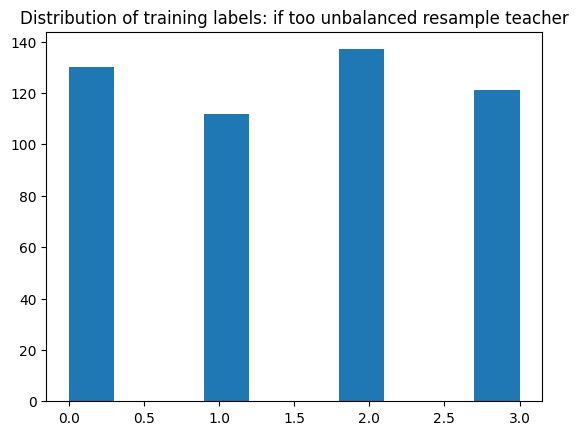

In [25]:
#making sure that the problem is not trivial: when generating artificial labels in fact the classes could be very unbalanced.
#if this is the case rerun  (hance changing the randomness in the teacher) until the classes are balanced
plt.hist(y_train.cpu().numpy())
plt.title("Distribution of training labels: if too unbalanced resample teacher")

In [26]:
"""
#zero
W=torch.zeros([C,d])
b=torch.zeros([C])
Z=torch.zeros([n,C])
"""
#informed
W=torch.clone(W_0)
b=torch.clone(b_0)
Z=torch.clone(Z_0)

W_norm=[]
b_norm=[]
Z_norm=[]
test_loss=[]
train_loss=[]
train_loss_noiseless=[]
score_Z=[]


In [27]:
X_train=X_train.to(device)
y_train=y_train.to(device)
y_train_noiseless=y_train_noiseless.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)
Delta=Delta.to(device)
lambda_W=lambda_W.to(device)
lambda_b=lambda_b.to(device)
W=W.to(device)
b=b.to(device)
Z=Z.to(device)

In [28]:
tmax=10000
for t in range(tmax):
    y_pred_train=argmax_layer_noiseless(X_train,W,b)
    y_pred_test=argmax_layer_noiseless(X_test,W,b)
    train_loss_noiseless.append(1-torch.sum(y_pred_train==y_train_noiseless).item()/y_train.shape[0])
    test_loss.append(1-torch.sum(y_pred_test==y_test).item()/y_test.shape[0])
    train_loss.append(1-torch.sum(y_pred_train==y_train).item()/y_train.shape[0])
    W_norm.append(torch.linalg.norm(W).item())
    Z_norm.append(torch.linalg.norm(Z).item())
    b_norm.append(torch.linalg.norm(b).item())
    score_Z.append(torch.mean(score_Z_resc(X_train,W,b,Z,Delta)).item())
    W=mc.sample_W_l_fcl(X_train,b,Z,lambda_W,Delta)
    b=mc.sample_b_l_fcl(W,Z,X_train,Delta,lambda_b)
    Z=mc.sample_Z_Lp1_multinomial_probit(X_train@(W.T)+b[None,:],Z,y_train,Delta)


In the following plot, with informed initialization, test error and train noiseless error should increase until they reach a plateau. The training error must instead be stationary from the beginning.

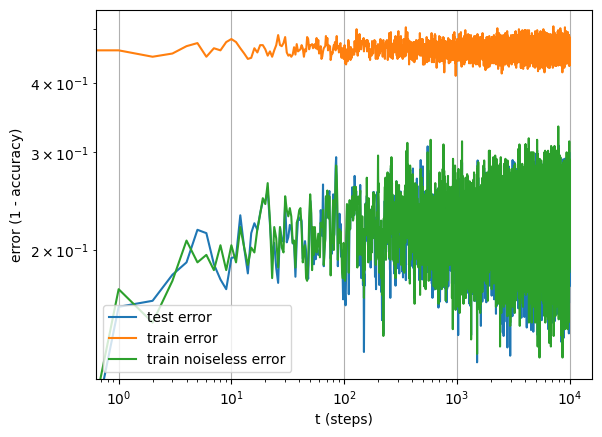

In [29]:
plt.plot(test_loss,label="test error")
plt.plot(train_loss,label="train error")
plt.plot(train_loss_noiseless,label="train noiseless error")
plt.xlabel("t (steps)")
plt.ylabel("error (1 - accuracy)")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()


All quantities below should be stationary. Moreover the rescaled score $\Delta\partial_W\log P$ should have mean zero.

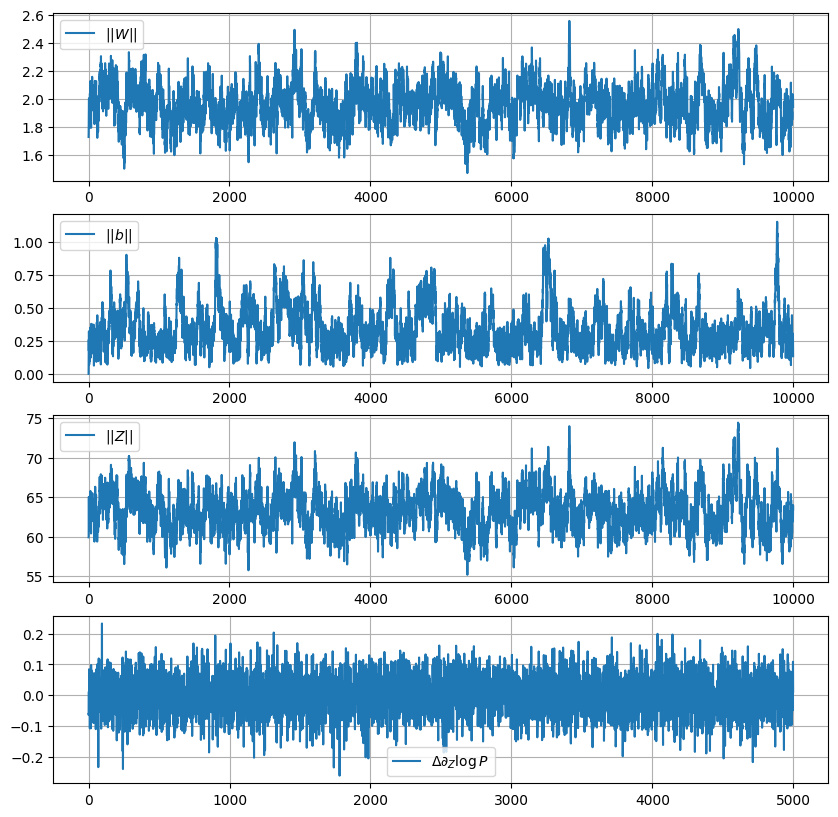

In [30]:
fig,axes=plt.subplots(4,1,figsize=[10,10])
axes[0].plot(W_norm[:],label=r"$||W||$")
axes[0].legend()
axes[0].grid()
axes[1].plot(b_norm[:],label=r"$||b||$")
axes[1].legend()
axes[1].grid()
axes[2].plot(Z_norm[:],label=r"$||Z||$")
axes[2].legend()
axes[2].grid()
axes[3].plot(score_resc_W_1[:],label=r"$\Delta\partial_{Z}\log P$")
axes[3].legend()
axes[3].grid()

# Convolutional Networks
We now conduct a series of experiments (always in the teacher student setting) to check that sampling functions for CNNs are correct.


We start by testing a convolutional layer followed by an average pooling layer.
This tests the functions `sample_W_l_conv2d`,`sample_X_l_avg_pooling`, `sample_b_l_conv2d`

$$X\underset{\text{convolution}}{\mapsto} Z \underset{\text{ReLU}}{\mapsto} X^{(2)} \underset{\text{pooling}}{\mapsto} Z^{(2)}$$

In [31]:
#test just one convolutional layer
#this does not cover the test of sample_X_l_conv2d.
# (X), conv2d (Z), ReLU (X_2), pooling (Z_2)
# X, Z_2 are fixed
torch.set_default_tensor_type(torch.DoubleTensor)
H_X=torch.tensor(6)
W_X=torch.tensor(6)
Sigma_X=torch.tensor(1)
n=torch.tensor(200)
C_X=torch.tensor(1)#number of input channels (e.g. 3 if RGB image)

#Convolutional layer
H_W=torch.tensor(3)
W_W=torch.tensor(3)
C_Z=torch.tensor(2)
stride_y=torch.tensor(1)
stride_x=torch.tensor(1)
lambda_W_0=H_W*W_W*C_X
lambda_b_0=H_W*W_W*C_X
H_Z=torch.div((H_X-H_W),stride_y,rounding_mode='floor') + 1
W_Z=torch.div(W_X-W_W,stride_x,rounding_mode='floor') + 1
Delta_Z_0=torch.tensor(1e-4)

#Nonlinearity
sigma_0=torch.nn.ReLU()
Delta_X_2_0=torch.tensor(1.5e-4)

#pooling
H_P=torch.tensor(2)
W_P=torch.tensor(2)
Delta_Z_2_0=torch.tensor(1e-4)
H_Z_2= torch.div(H_Z,H_P,rounding_mode='floor')
W_Z_2= torch.div(W_Z,W_P,rounding_mode='floor')


In [32]:
def conv2d_relu_pool_noiseless(sigma,W,b,stride_y,stride_x,H_P,W_P,X):
    n,_,H_X,W_X=X.shape
    C_lp1,C_l,H_W,W_W=W.shape
    H_out=torch.div(H_X-H_W,stride_y,rounding_mode='floor') + 1
    W_out=torch.div(W_X-W_W,stride_x,rounding_mode='floor') + 1
    Z=mc.conv2d_layer(X,W,stride_y,stride_x)+b[None,:,None,None]
    X_2=sigma(Z)
    Z_2=mc.average_pool2d(X_2,H_P,W_P)
    return Z_2

def conv2d_relu_pool(sigma,W,b,stride_y,stride_x,H_P,W_P,noise_Z,noise_X_2,noise_Z_2,X):
    n,_,H_X,W_X=X.shape
    C_lp1,C_l,H_W,W_W=W.shape
    H_out=torch.div(H_X-H_W,stride_y,rounding_mode='floor') + 1
    W_out=torch.div(W_X-W_W,stride_x,rounding_mode='floor') + 1
    Z=mc.conv2d_layer(X,W,stride_y,stride_x)+b[None,:,None,None]+noise_Z
    X_2=sigma(Z)+noise_X_2
    Z_2=mc.average_pool2d(X_2,H_P,W_P)+noise_Z_2
    return Z_2

In [33]:
#sample teacher
W_0=(torch.randn(size=[C_Z,C_X,H_W,W_W])/torch.sqrt(lambda_W_0))
b_0=(torch.randn(size=[C_Z])/torch.sqrt(lambda_b_0))

#sample input data
X_train=torch.randn(size=[n,C_X,H_X,W_X])
#sample noise
noise_Z=torch.randn(size=[n,C_Z,H_Z,W_Z])*torch.sqrt(Delta_Z_0)
noise_X_2=torch.randn(size=[n,C_Z,H_Z,W_Z])*torch.sqrt(Delta_X_2_0)
noise_Z_2=torch.randn(size=[n,C_Z,H_Z_2,W_Z_2])*torch.sqrt(Delta_Z_2_0)

#generate output
Z_2_train=conv2d_relu_pool(sigma_0,W_0,b_0,stride_y,stride_x,H_P,W_P,noise_Z,noise_X_2,noise_Z_2,X_train)
Z_2_train_noiseless=conv2d_relu_pool_noiseless(sigma_0,W_0,b_0,stride_y,stride_x,H_P,W_P,X_train)

n,_,H_X,W_X=X_train.shape
C_lp1,C_l,H_W,W_W=W_0.shape
H_out=torch.div(H_X-H_W,stride_y,rounding_mode='floor') + 1
W_out=torch.div(W_X-W_W,stride_x,rounding_mode='floor') + 1

Z_0=Z=mc.conv2d_layer(X_train,W_0,stride_y,stride_x)+b_0[None,:,None,None]+noise_Z
X_2_0=sigma_0(Z_0)+noise_X_2
Z_2_0=mc.average_pool2d(X_2_0,H_P,W_P) + noise_Z_2

#generate test set
n_test=1000
X_test=torch.randn(size=[n,C_X,H_X,W_X])
Z_2_test=conv2d_relu_pool_noiseless(sigma_0,W_0,b_0,stride_y,stride_x,H_P,W_P,X_test)

In [34]:
#INITIALIZATIONS

#informed initialization
W=W_0.clone()
b=b_0.clone()
Z=Z_0.clone()
X_2=X_2_0.clone()

"""
#zero initialization
W=torch.zeros(W_0.shape)
b=torch.zeros(b_0.shape)
Z=torch.zeros(Z_0.shape)
X_2=torch.zeros(X_2_0.shape)
"""

'\n#zero initialization\nW=torch.zeros(W_0.shape)\nb=torch.zeros(b_0.shape)\nZ=torch.zeros(Z_0.shape)\nX_2=torch.zeros(X_2_0.shape)\n'

In [35]:
#X_train[:,:,::stride_y,::stride_x][:,:,:H_Z,:W_Z].shape
Z.shape

torch.Size([200, 2, 4, 4])

In [36]:
def score_W_l_conv2d_resc(X_l,W_l,b_l,Z_lp1,lambda_W_l,Delta_Z_lp1,stride_y,stride_x):
    """
    Computes the score by deriving the log posterior with respect to W_l. Then the result is multiplied by Delta_Z_lp1.

    returns a tensor of the sam shape as W_l. Every entry of the returned tensor has mean zero under the posterior.
    W_l is supposed to be the weight vector in a convolutional layer
    """
    score=-Delta_Z_lp1*lambda_W_l*W_l
    C_Z_lp1,C_X_l,H_W,W_W=W_l.shape
    H_Z,W_Z=Z_lp1.shape[-2:]
    output_conv=mc.conv2d_layer(X_l,W_l,stride_y,stride_x)
    for r_x in range(W_W):
        for r_y in range(H_W):
            score[:,:,r_y,r_x]-=torch.tensordot(Z_lp1-output_conv-b_l[None,:,None,None],X_l[:,:,::stride_y,::stride_x][:,:,:H_Z,:W_Z],[[0,2,3],[0,2,3]])
    return score

In [37]:
lambda_W=lambda_W_0.to(device)
lambda_b=lambda_b_0.to(device)
Delta_Z=Delta_Z_0.to(device)
Delta_Z_2=Delta_Z_2_0.to(device)
Delta_X_2=Delta_X_2_0.to(device)
W=W.to(device)
b=b.to(device)
Z=Z.to(device)
X_2=X_2.to(device)
sigma=sigma_0

#moving things to device
X_train=X_train.to(device)
X_test=X_test.to(device)
Z_2_test=Z_2_test.to(device)
Z_2_train=Z_2_train.to(device)
Z_2_train_noiseless=Z_2_train_noiseless.to(device)


W_norm=[]
b_norm=[]
X_2_norm=[]
Z_norm=[]
train_loss=[]
test_loss=[]
train_loss_noiseless=[]
score_W_resc=[]

In [38]:
if(str(device)=='cuda'):
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [39]:
# (X), conv2d (Z), ReLU (X_2), pooling (Z_2)
tmax=1000
for t in range(tmax):
    Z_2_pred_train=conv2d_relu_pool_noiseless(sigma,W,b,stride_y,stride_x,H_P,W_P,X_train)
    Z_2_pred_test=conv2d_relu_pool_noiseless(sigma,W,b,stride_y,stride_x,H_P,W_P,X_test)
    train_loss_noiseless.append(torch.mean((Z_2_pred_train-Z_2_train_noiseless)**2).item())
    train_loss.append(torch.mean((Z_2_pred_train-Z_2_train)**2).item())
    test_loss.append(torch.mean((Z_2_pred_test-Z_2_test)**2).item())
    W_norm.append(torch.linalg.norm(W).item())
    b_norm.append(torch.linalg.norm(b).item())
    Z_norm.append(torch.linalg.norm(Z).item())
    X_2_norm.append(torch.linalg.norm(X_2).item())
    score_W_resc.append(torch.mean(score_W_l_conv2d_resc(X_train,W,b,Z,lambda_W,Delta_Z,stride_y,stride_x)).item())
    
    X_2=mc.sample_X_l_avg_pooling(sigma(Z),Z_2_train,Delta_X_2,Delta_Z_2)
    
    Z=mc.sample_Z_lp1_relu(mc.conv2d_layer(X_train,W,stride_y,stride_x)+b[None,:,None,None],X_2,Delta_Z,Delta_X_2)

    #special update for first layer weights
    #W=mc.sample_W_1_conv2d(Cholesky_Cov_W_resc, Cov_W_resc_XT,b,Z,Delta_Z, H_W, W_W, C_1)
    #W=mc.sample_W_l_conv2d_lowmem(X,b,Z,lambda_W,Delta_Z,stride_y,stride_x, H_W, W_W)
    W=mc.sample_W_l_conv2d(X_train,b,Z,lambda_W,Delta_Z,stride_y,stride_x, H_W, W_W)
    b=mc.sample_b_l_conv2d(X_train,Z,W,Delta_Z,lambda_b,stride_y,stride_x)

In the following plot, with informed initialization, test MSE and train noiseless MSE should increase until they reach a plateau. The training MSE must instead be stationary from the beginning.

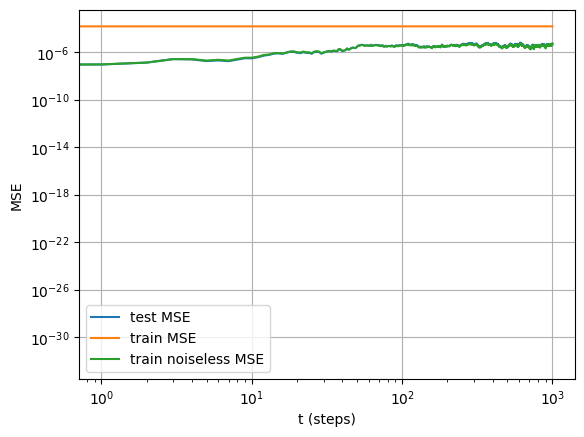

In [40]:
plt.plot(test_loss,label="test MSE")
plt.plot(train_loss,label="train MSE")
plt.plot(train_loss_noiseless,label="train noiseless MSE")
plt.xlabel("t (steps)")
plt.ylabel("MSE")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()

All quantities plotted below should be stationary from the beginning. Moreover the score $\Delta\partial_W\log P$ must have mean zero from the beginning.

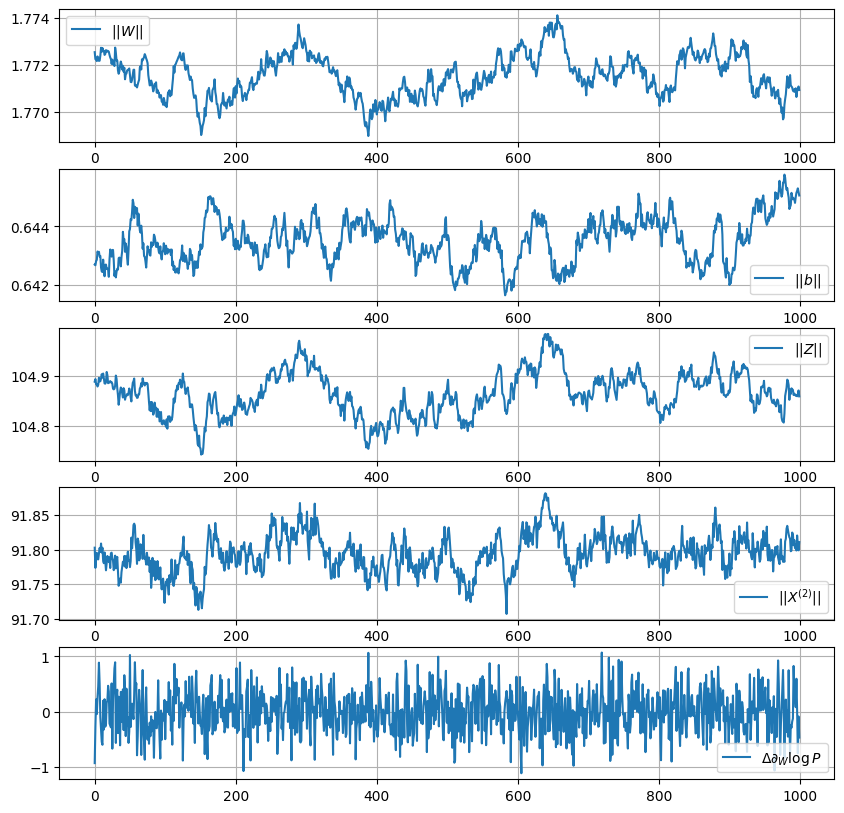

In [41]:
fig,axes=plt.subplots(5,1,figsize=[10,10])
axes[0].plot(W_norm[:],label=r"$||W||$")
axes[0].legend()
axes[0].grid()
axes[1].plot(b_norm[:],label=r"$||b||$")
axes[1].legend()
axes[1].grid()
axes[2].plot(Z_norm[:],label=r"$||Z||$")
axes[2].legend()
axes[2].grid()
axes[3].plot(X_2_norm[:],label=r"$||X^{(2)}||$")
axes[3].legend()
axes[3].grid()
axes[4].plot(score_W_resc[:],label=r"$\Delta\partial_{W}\log P$")
axes[4].legend()
axes[4].grid()

# Test `sample_W_1_conv2d`
same architecture and poterior as before, only this time we use the faster implementation to sample the first layer's weights. Analogously to the fuly connected case, this method basically consists of precomputing the covariance matrix of the convolutional weights.

In [42]:
#INITIALIZATIONS

#informed initialization
W=W_0.clone()
b=b_0.clone()
Z=Z_0.clone()
X_2=X_2_0.clone()

"""
#zero initialization
W=torch.zeros(W_0.shape)
b=torch.zeros(b_0.shape)
Z=torch.zeros(Z_0.shape)
X_2=torch.zeros(X_2_0.shape)
"""

'\n#zero initialization\nW=torch.zeros(W_0.shape)\nb=torch.zeros(b_0.shape)\nZ=torch.zeros(Z_0.shape)\nX_2=torch.zeros(X_2_0.shape)\n'

In [43]:
#precomputing quantities
if(str(device)=='cuda'):
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

#precomputable things
lambda_W_1=lambda_W

n,C_2,H_Z,W_Z=Z.shape
C_1=X_train.shape[1]     

jump_y,jump_x=X_train.stride()[-2:] #number of positions I have to move in memory to go to the next  3rd, 4th index respectively in X_l.
X_strided_shape=(n,C_1,H_W,W_W,H_Z,W_Z) 
X_strides=X_train.stride()+(stride_y*jump_y,stride_x*jump_x)

X_strided=torch.as_strided(X_train,size=X_strided_shape, stride=X_strides)
A_tilde_resc=torch.tensordot(X_strided,X_strided, [[0,4,5],[0,4,5]])

A_resc=A_tilde_resc.reshape([C_1*H_W*W_W,C_1*H_W*W_W]) 
A_resc=A_resc+lambda_W_1*Delta_Z*torch.eye(C_1*H_W*W_W)
Cov_W_resc=torch.linalg.inv(A_resc)  
Cholesky_Cov_W_resc=torch.linalg.cholesky(Cov_W_resc)  #<---should be passed as argument
Cov_W_resc_XT=torch.tensordot(Cov_W_resc.reshape([C_1*H_W*W_W,C_1,H_W,W_W]),X_strided,[[1,2,3],[1,2,3]]) #<--- should be passed as argument

In [44]:
lambda_W=lambda_W_0.to(device)
lambda_b=lambda_b_0.to(device)
Delta_Z=Delta_Z_0.to(device)
Delta_Z_2=Delta_Z_2_0.to(device)
Delta_X_2=Delta_X_2_0.to(device)
W=W.to(device)
b=b.to(device)
Z=Z.to(device)
X_2=X_2.to(device)
sigma=sigma_0

#moving things to device
X_train=X_train.to(device)
X_test=X_test.to(device)
Z_2_test=Z_2_test.to(device)
Z_2_train=Z_2_train.to(device)
Z_2_train_noiseless=Z_2_train_noiseless.to(device)


W_norm=[]
b_norm=[]
X_2_norm=[]
Z_norm=[]
train_loss=[]
test_loss=[]
train_loss_noiseless=[]
score_W_resc=[]

In [45]:
tmax=10000
for t in range(tmax):
    Z_2_pred_train=conv2d_relu_pool_noiseless(sigma,W,b,stride_y,stride_x,H_P,W_P,X_train)
    Z_2_pred_test=conv2d_relu_pool_noiseless(sigma,W,b,stride_y,stride_x,H_P,W_P,X_test)
    train_loss_noiseless.append(torch.mean((Z_2_pred_train-Z_2_train_noiseless)**2).item())
    train_loss.append(torch.mean((Z_2_pred_train-Z_2_train)**2).item())
    test_loss.append(torch.mean((Z_2_pred_test-Z_2_test)**2).item())
    W_norm.append(torch.linalg.norm(W).item())
    b_norm.append(torch.linalg.norm(b).item())
    Z_norm.append(torch.linalg.norm(Z).item())
    X_2_norm.append(torch.linalg.norm(X_2).item())
    score_W_resc.append(torch.mean(score_W_l_conv2d_resc(X_train,W,b,Z,lambda_W,Delta_Z,stride_y,stride_x)).item())

    #score_W_resc.append(score_W_l_conv2d_resc(X_train,W,b,Z,lambda_W,Delta_Z,stride_y,stride_x))
    X_2=mc.sample_X_l_avg_pooling(sigma(Z),Z_2_train,Delta_X_2,Delta_Z_2)
    Z=mc.sample_Z_lp1_relu(mc.conv2d_layer(X_train,W,stride_y,stride_x)+b[None,:,None,None],X_2,Delta_Z,Delta_X_2)

    #special update for first layer weights
    W=mc.sample_W_1_conv2d(Cholesky_Cov_W_resc, Cov_W_resc_XT,b,Z,Delta_Z, H_W, W_W, C_1)
    b=mc.sample_b_l_conv2d(X_train,Z,W,Delta_Z,lambda_b,stride_y,stride_x)

In the following plot, with informed initialization, test MSE and train noiseless MSE should increase until they reach a plateau. The training MSE must instead be stationary from the beginning.

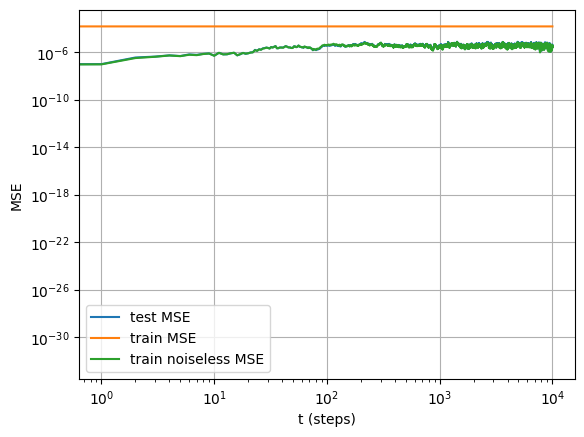

In [46]:
plt.plot(test_loss,label="test MSE")
plt.plot(train_loss,label="train MSE")
plt.plot(train_loss_noiseless,label="train noiseless MSE")
plt.xlabel("t (steps)")
plt.ylabel("MSE")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()

All quantities plotted below should be stationary from the beginning of the dynamics

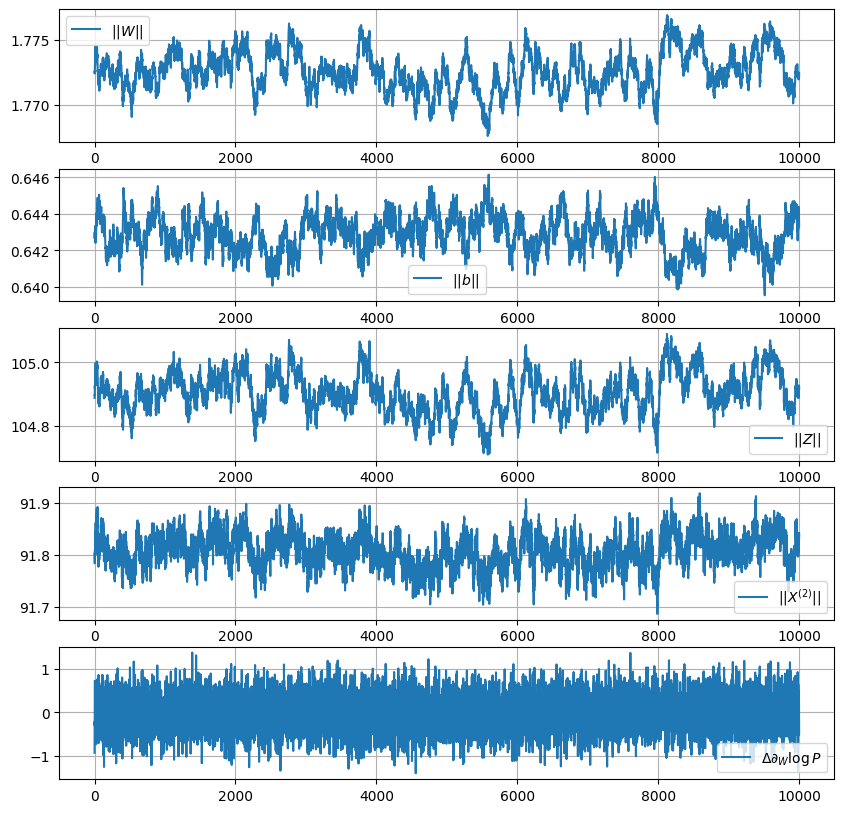

In [47]:
fig,axes=plt.subplots(5,1,figsize=[10,10])
axes[0].plot(W_norm[:],label=r"$||W||$")
axes[0].legend()
axes[0].grid()
axes[1].plot(b_norm[:],label=r"$||b||$")
axes[1].legend()
axes[1].grid()
axes[2].plot(Z_norm[:],label=r"$||Z||$")
axes[2].legend()
axes[2].grid()
axes[3].plot(X_2_norm[:],label=r"$||X^{(2)}||$")
axes[3].legend()
axes[3].grid()
axes[4].plot(score_W_resc[:],label=r"$\Delta\partial_{W}\log P$")
axes[4].legend()
axes[4].grid()

# Test `sample_X_l_conv2d` (i.e. test the sampling of the middle layer)
Here we test in particular the function `sample_X_l_conv2d` and an alternative (less memory hungry) function to sample $W$: `sample_W_l_conv2d_lowmem`.

We test these functions on the architecture
$$X\underset{\text{ReLU}}{\mapsto} X^{(2)} \underset{\text{conv2d}}{\mapsto} Z^{(2)}$$. After the ReLU and after the convolution a small noise is applied in the teacher.

In [48]:
torch.set_default_tensor_type(torch.DoubleTensor)
#test just one convolutional layer
#this does not cover the test of sample_X_l_conv2d.
# (X), ReLU (X_2), conv2d (Z_2)
# X, Z_2 are fixed
#Input
H_X=torch.tensor(6)
W_X=torch.tensor(6)
n=torch.tensor(400)
C_X=torch.tensor(1) #input chanels (e.g. 3 if RGB image)



#Nonlinearity
sigma_0=torch.nn.ReLU()
Delta_X_2_0=torch.tensor(1.5e-4)
H_X_2=H_X
W_X_2=W_X
C_X_2=C_X

#Convolutional layer
H_W_2=torch.tensor(2)
W_W_2=torch.tensor(2)
C_Z_2=torch.tensor(1)

stride_y_2=torch.tensor(1)
stride_x_2=torch.tensor(1)
lambda_W_2_0=(H_W_2*W_W_2*C_X)
lambda_b_2_0=(H_W_2*W_W_2*C_X)

Delta_Z_2_0=torch.tensor(1e-4)
H_Z_2=torch.div(H_X_2-H_W_2,stride_y_2,rounding_mode='floor') + 1
W_Z_2=torch.div(W_X_2-W_W_2,stride_x_2,rounding_mode='floor') + 1
                        
                        

In [49]:
def conv2d_relu_noiseless(X,sigma,W_2,b_2,stride_y_2,stride_x_2):
    X_2=sigma(X)
    Z_2=mc.conv2d_layer(X_2,W_2,stride_y_2,stride_x_2)+b_2[None,:,None,None]
    return Z_2

def conv2d_relu(X,sigma,W_2,b_2,stride_y_2,stride_x_2,noise_X_2,noise_Z_2):
    X_2=sigma(X)+noise_X_2
    Z_2=mc.conv2d_layer(X_2,W_2,stride_y_2,stride_x_2)+b_2[None,:,None,None]+noise_Z_2
    return Z_2

In [50]:
#sample teacher weights
W_2_0=torch.randn(size=[C_Z_2,C_X_2,H_W_2,W_W_2])/torch.sqrt(lambda_W_2_0)
b_2_0=torch.randn(size=[C_Z_2])/torch.sqrt(lambda_b_2_0)

In [51]:
#sample input data
X_train=torch.randn(size=[n,C_X,H_X,W_X])

#sample noise
noise_X_2=torch.randn(size=[n,C_X_2,H_X_2,W_X_2])*torch.sqrt(Delta_X_2_0)
noise_Z_2=torch.randn(size=[n,C_Z_2,H_Z_2,W_Z_2])*torch.sqrt(Delta_Z_2_0)

#generate output
Z_2_train=conv2d_relu(X_train,sigma_0,W_2_0,b_2_0,stride_y_2,stride_x_2,noise_X_2,noise_Z_2)
Z_2_train_noiseless=conv2d_relu_noiseless(X_train,sigma_0,W_2_0,b_2_0,stride_y_2,stride_x_2)

X_2_0=sigma_0(X_train)+noise_X_2
Z_2_0=mc.conv2d_layer(X_2_0,W_2_0,stride_y_2,stride_x_2)+b_2_0[None,:,None,None]+ noise_Z_2

In [52]:
#generate test set
n_test=1000
X_test=torch.randn(size=[n_test,C_X,H_X,W_X])
Z_2_test=conv2d_relu_noiseless(X_test,sigma_0,W_2_0,b_2_0,stride_y_2,stride_x_2)

In [53]:
lambda_W=lambda_W_0.to(device)
lambda_b=lambda_b_0.to(device)
Delta_Z=Delta_Z_0.to(device)
Delta_X_2=Delta_X_2_0.to(device)
lambda_W_2=lambda_W_2_0.to(device)
lambda_b_2=lambda_b_2_0.to(device)
Delta_Z_2=Delta_Z_2_0.to(device)
sigma=sigma_0

#INITIALIZATIONS

#informed initialization
W=W_0.clone().to(device)
b=b_0.clone().to(device)
Z=Z_0.clone().to(device)
X_2=X_2_0.clone().to(device)
W_2=W_2_0.clone().to(device)
b_2=b_2_0.clone().to(device)

"""
#zero initialization
W=torch.zeros(W_0.shape).to(device)
b=torch.zeros(b_0.shape).to(device)
Z=torch.zeros(Z_0.shape).to(device)
X_2=torch.zeros(X_2_0.shape).to(device)
W_2=torch.zeros(W_2_0.shape).to(device)
b_2=torch.zeros(b_2_0.shape).to(device)
"""

#move things to device
X_train=X_train.to(device)
X_test=X_test.to(device)
Z_2_test=Z_2_test.to(device)
Z_2_train=Z_2_train.to(device)
Z_2_train_noiseless=Z_2_train_noiseless.to(device)

#quantities to track
W_2_norm=[]
b_2_norm=[]
X_2_norm=[]
train_loss=[]
train_loss_noiseless=[]
test_loss=[]
score_W_2_resc=[]

In [54]:
if(str(device)=='cuda'):
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [55]:
# (X), ReLU (X_2), conv2d (Z_2)
tmax=1000
for t in range(tmax):
    Z_2_pred_train=conv2d_relu_noiseless(X_train,sigma,W_2,b_2,stride_y_2,stride_x_2)
    Z_2_pred_test=conv2d_relu_noiseless(X_test,sigma,W_2,b_2,stride_y_2,stride_x_2)
    train_loss_noiseless.append(torch.mean((Z_2_pred_train-Z_2_train_noiseless)**2).item())
    train_loss.append(torch.mean((Z_2_pred_train-Z_2_train)**2).item())
    test_loss.append(torch.mean((Z_2_pred_test-Z_2_test)**2).item())
    W_2_norm.append(torch.linalg.norm(W_2).item())
    b_2_norm.append(torch.linalg.norm(b_2).item())
    X_2_norm.append(torch.linalg.norm(X_2).item())
    score_W_2_resc.append(torch.mean(score_W_l_conv2d_resc(X_2,W_2,b_2,Z_2_train,lambda_W_2,Delta_Z_2,stride_y_2,stride_x_2)).item())

    #updating the variables
    W_2=mc.sample_W_l_conv2d_lowmem(X_2,b_2,Z_2_train,lambda_W_2,Delta_Z_2,stride_y,stride_x, H_W_2, W_W_2)
    b_2=mc.sample_b_l_conv2d(X_2,Z_2_train,W_2,Delta_Z_2,lambda_b_2,stride_y_2,stride_x_2)
    X_2=mc.sample_X_l_conv2d(sigma(X_train),W_2,b_2,Z_2_train,Delta_X_2,Delta_Z_2,stride_y_2,stride_x_2)

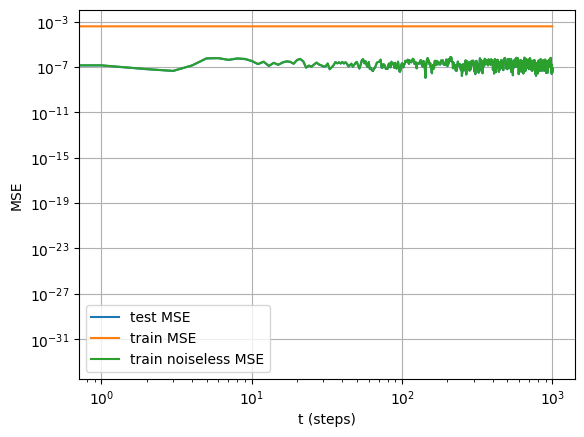

In [56]:
plt.plot(test_loss,label="test MSE")
plt.plot(train_loss,label="train MSE")
plt.plot(train_loss_noiseless,label="train noiseless MSE")
plt.xlabel("t (steps)")
plt.ylabel("MSE")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()

All quantities plotted below should be stationary from the beginning, and $\Delta\partial_{W}\log P$ should have mean zero from the beginning.

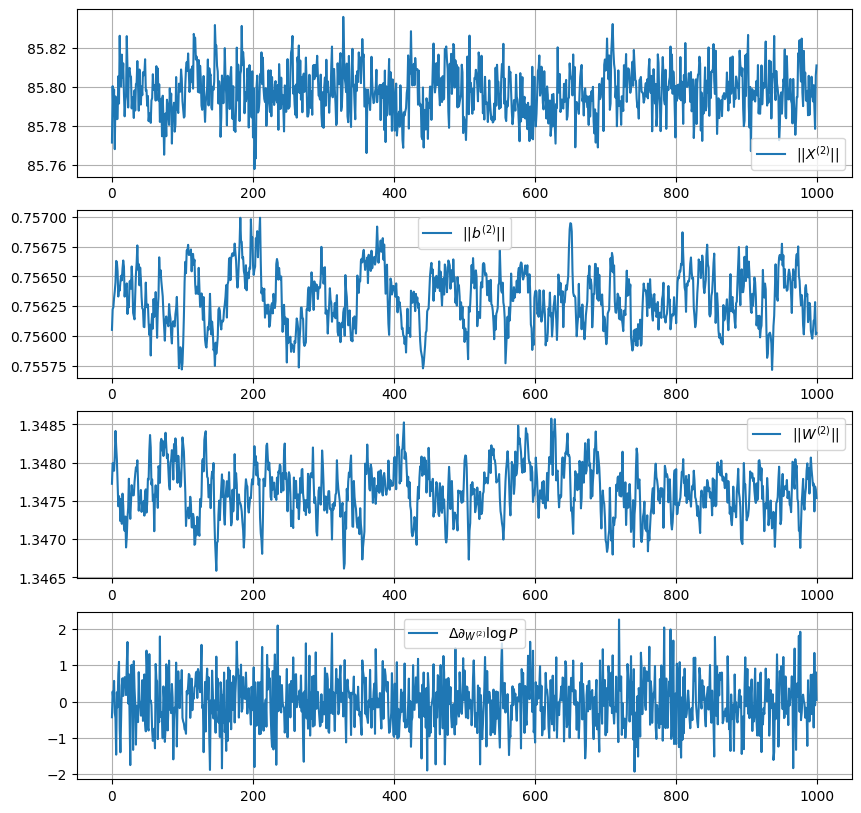

In [57]:
fig,axes=plt.subplots(4,1,figsize=[10,10])
axes[0].plot(X_2_norm[:],label=r"$||X^{(2)}||$")
axes[0].legend()
axes[0].grid()
axes[1].plot(b_2_norm[:],label=r"$||b^{(2)}||$")
axes[1].legend()
axes[1].grid()
axes[2].plot(W_2_norm[:],label=r"$||W^{(2)}||$")
axes[2].legend()
axes[2].grid()
axes[3].plot(score_W_2_resc[:],label=r"$\Delta\partial_{W^{(2)}}\log P$")
axes[3].legend()
axes[3].grid()